# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if y.size == 0:
        return 0

    mean_y = np.mean(y)
    absolute_deviation = np.abs(y - mean_y)
    mean_absolute_deviation = np.mean(absolute_deviation)

    return mean_absolute_deviation

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    R = len(y)
    
    # Split the data into left and right child nodes
    R_l = y[X[:, j] <= t]
    R_r = y[X[:, j] > t]
    
    # Calculate impurity for left and right child nodes using H() function
    impurity_l = H(R_l)
    impurity_r = H(R_r)
    
    # Calculate the weighted impurity of the children
    weighted_impurity = (len(R_l) / R) * impurity_l + (len(R_r) / R) * impurity_r
    
    # Calculate the information gain (decrease in impurity)
    Q = H(y) - weighted_impurity
    
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import r2_score

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        best_split_column = None
        best_threshold = None
        best_cost = H(y)  # without splitting
        X_left, y_left, X_right, y_right = None, None, None, None

        for j in range(X.shape[1]):  # iterate over features
            thresholds = np.unique(X[:, j])
            for t in thresholds:
                # Split data
                R_l = y[X[:, j] <= t]
                R_r = y[X[:, j] > t]

                # Skip splits that don't meet min_samples_leaf condition
                if len(R_l) < self.min_samples_leaf or len(R_r) < self.min_samples_leaf:
                    continue

                # Calculate cost function
                cost = Q(X, y, j, t)

                # Update best split if the cost is lower
                if cost > best_cost:
                    best_cost = cost
                    best_split_column = j
                    best_threshold = t
                    X_left = X[X[:, j] <= t]
                    y_left = y[X[:, j] <= t]
                    X_right = X[X[:, j] > t]
                    y_right = y[X[:, j] > t]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal =True
            return
                
        # Find the best split
        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if best_split_column is None:  # no good split found
            node.is_terminal = True
            return

        # Update node properties with the best split
        node.column = best_split_column
        node.threshold = best_threshold
        node.left = Node()
        node.left.depth = node.depth + 1
        node.right = Node()
        node.right.depth = node.depth + 1

        # Recursively grow the tree for the left and right children
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if x[node.column] <= node.threshold:
            return self.get_prediction(node.left, x)
        else:
            return self.get_prediction(node.right, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

AssertionError: 

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [8]:
# from sklearn.datasets import load_boston 
# It was deleted from sklearn

data_url = "http://lib.stat.cmu.edu/datasets/boston"

In [25]:
names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([data.values[::2, :], data.values[1::2, :2]])
y = data.values[1::2, 2]

ValueError: x and y must be the same size

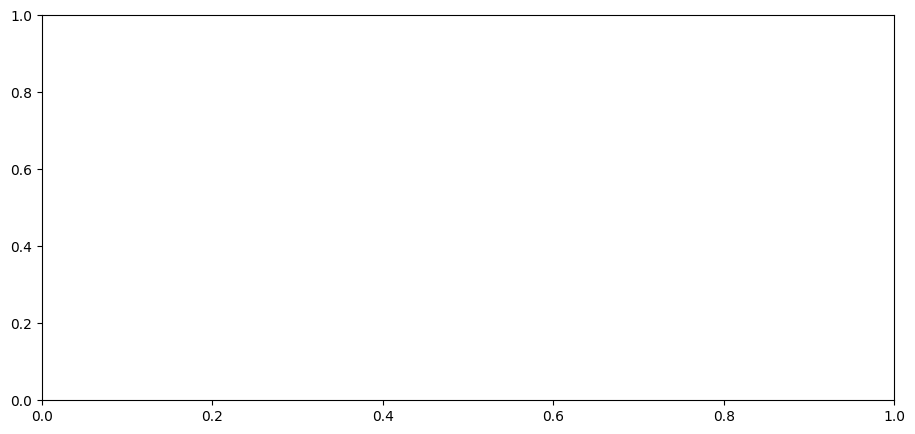

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_absolute_error

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to fit a decision tree, create visualizations, and compare MAE
def fit_and_visualize_tree(max_depth, X_train, y_train, X_test, y_test):
    # Fit MyDecisionTreeRegressor
    tree = MyDecisionTreeRegressor(max_depth=max_depth, min_samples_split=5, min_samples_leaf=2)
    tree.fit(X_train, y_train)

    # Scatter plot of training points
    plt.scatter(X_train[:, tree.tree_.column], y_train, label='Training Data')
    plt.xlabel(f"Feature {tree.tree_.column}")
    plt.ylabel("Target Variable")
    plt.title(f"Scatter Plot of Training Points (Depth {max_depth})")
    plt.legend()
    plt.show()

    # Visualize the decision tree
    tree_rules = export_text(tree, feature_names=names)
    print(f"Decision Tree Rules (Depth {max_depth}):\n{tree_rules}")

    # Compare MAE on train and test
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"MAE on Train (Depth {max_depth}): {mae_train:.2f}")
    print(f"MAE on Test (Depth {max_depth}): {mae_test:.2f}")

# Fit and visualize MyDecisionTreeRegressor with depths 1, 3, and 5
for depth in [1, 3, 5]:
    fit_and_visualize_tree(depth, X_train, y_train, X_test, y_test)


### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [ ]:
# YOUR CODE HERE

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [ ]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    # YOUR CODE HERE

In [ ]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 10)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [ ]:
# YOUR CODE HERE

``` your comments here```

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor

# YOUR CODE HERE

```your comments here```

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [2]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('Billionaires Statistics Dataset.csv')

# Drop columns with a lot of missing values or deemed not useful
threshold = 0.3
df = df.dropna(thresh=(1 - threshold) * df.shape[0], axis=1)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('selfMade', axis=1), df['selfMade'], test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

# Create transformers for categorical and numerical columns
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # You can choose another strategy if needed
    OneHotEncoder(handle_unknown='ignore')
)

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),  # You can choose another strategy if needed
    StandardScaler()
)

# Create the column transformer
column_transformer = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_cols),
        ('numeric', numeric_transformer, numeric_cols)
    ],
    remainder='passthrough'
)

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [4]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Increase max_iter for Logistic Regression and add StandardScaler
models = {
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Define classification metric
scorer = make_scorer(f1_score)

# Calculate class weights for handling class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Create StandardScaler for Logistic Regression
logreg_scaler = StandardScaler(with_mean=False)  # Set with_mean=False for sparse matrices

# Compare models using cross-validation
results = {}
for model_name, model in models.items():
    if model_name == 'Logistic Regression':
        # Apply StandardScaler to Logistic Regression
        model = make_pipeline(logreg_scaler, model)
    scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
    results[model_name] = scores

# Display the cross-validation results using mean F1 score
for model_name, scores in results.items():
    print(f"{model_name}: F1 Score - Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")

# Identify the model with the best performance
best_model = max(results, key=lambda k: results[k].mean())
print(f"\nBest Model: {best_model}")

Gradient Boosting: F1 Score - Mean: 0.8624, Std: 0.0067
Random Forest: F1 Score - Mean: 0.8740, Std: 0.0048
Decision Tree: F1 Score - Mean: 0.8293, Std: 0.0223
SVM: F1 Score - Mean: 0.8572, Std: 0.0069
Logistic Regression: F1 Score - Mean: 0.8786, Std: 0.0052

Best Model: Logistic Regression


- Я использовал F1 Score в качестве метрики классификации, так как она подходит лучше всего в случае наличия дисбаланса в наборах данных: F1 учитывает как точность, так и полноту.
- Лучшие результат показала Logistic regression (F1 score - Mean = 0.8786).
- Судя по стандартному отклонению, Decision Tree может быть переобучена (достаточно высокое Std и Mean), прочие модели вероятно недообучены относительно Логистической регрессии (более низкий Mean, при низких Std).

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [7]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Add XGBoost to the models
models['XGBoost'] = xgb.XGBClassifier()

# Define hyperparameter grid for XGBoost
param_grid_xgboost = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 7]
}

# Use GridSearchCV to find the best hyperparameters for XGBoost
grid_search_xgboost = GridSearchCV(models['XGBoost'], param_grid=param_grid_xgboost, scoring=scorer, cv=StratifiedKFold(n_splits=5))
grid_search_xgboost.fit(X_train, y_train)

# Display the best hyperparameters for XGBoost
best_params_xgboost = grid_search_xgboost.best_params_
print(f"Best Hyperparameters for XGBoost: {best_params_xgboost}")

# Train XGBoost with the best hyperparameters
best_xgboost_model = xgb.XGBClassifier(**best_params_xgboost)
best_xgboost_model.fit(X_train, y_train)

# Evaluate the performance of XGBoost
xgboost_scores = cross_val_score(best_xgboost_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
print(f"\nXGBoost: F1 Score - Mean: {xgboost_scores.mean():.4f}, Std: {xgboost_scores.std():.4f}")

# Compare XGBoost with other models
for model_name, scores in results.items():
    if model_name != 'XGBoost':
        if xgboost_scores.mean() > scores.mean():
            print(f"XGBoost outperforms {model_name}.")
        elif xgboost_scores.mean() < scores.mean():
            print(f"{model_name} outperforms XGBoost.")
        else:
            print(f"{model_name} has similar performance to XGBoost.")

Best Hyperparameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}

XGBoost: F1 Score - Mean: 0.8606, Std: 0.0052
Gradient Boosting outperforms XGBoost.
Random Forest outperforms XGBoost.
XGBoost outperforms Decision Tree.
XGBoost outperforms SVM.
Logistic Regression outperforms XGBoost.


Обученный с наилучшими гиперпараметрами XGBoost превосходит по Mean и Std Decision Tree и SVM. Остальные модели превосходят XGBoost по Mean, однако Std у XGBoost меньше, чем у Gradient Boosting и равно таковому у Logistic Regression. Соответственно, в некоторых случаях XGBoost лучше, чем у Gradient Boosting.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [9]:
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Bagging with decision trees
bagging_dt_model = BaggingClassifier(estimator=DecisionTreeClassifier(),
                                     n_estimators=50,
                                     random_state=42)
bagging_dt_scores = cross_val_score(bagging_dt_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
print(f"Bagging with Decision Trees: F1 Score - Mean: {bagging_dt_scores.mean():.4f}, Std: {bagging_dt_scores.std():.4f}")

Bagging with Decision Trees: F1 Score - Mean: 0.8583, Std: 0.0085


In [10]:
# Bagging with gradient boosting
bagging_gb_model = BaggingClassifier(estimator=GradientBoostingClassifier(n_estimators=200),
                                     n_estimators=10,
                                     random_state=42)
bagging_gb_scores = cross_val_score(bagging_gb_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
print(f"Bagging with Gradient Boosting: F1 Score - Mean: {bagging_gb_scores.mean():.4f}, Std: {bagging_gb_scores.std():.4f}")

Bagging with Gradient Boosting: F1 Score - Mean: 0.8672, Std: 0.0089


In [16]:
# Voting classifier
voting_model = VotingClassifier(estimators=[('gb', GradientBoostingClassifier(n_estimators=200)),
                                            ('rf', RandomForestClassifier(n_estimators=100)),
                                            ('logreg', make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000)))],
                                            voting='soft')
voting_scores = cross_val_score(voting_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
print(f"Voting Classifier: F1 Score - Mean: {voting_scores.mean():.4f}, Std: {voting_scores.std():.4f}")

Voting Classifier: F1 Score - Mean: 0.8866, Std: 0.0052


In [12]:
# Stacking classifier with Logistic Regression as a final model
stacking_lr_model = StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=100)),
                                                   ('gb', GradientBoostingClassifier(n_estimators=200))],
                                       final_estimator=make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
                                       cv=StratifiedKFold(n_splits=5))
stacking_lr_scores = cross_val_score(stacking_lr_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
print(f"Stacking Classifier with Logistic Regression: F1 Score - Mean: {stacking_lr_scores.mean():.4f}, Std: {stacking_lr_scores.std():.4f}")

Stacking Classifier with Logistic Regression: F1 Score - Mean: 0.8715, Std: 0.0102


In [13]:
# Stacking classifier with Gradient Boosting as a final model
stacking_gb_model = StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators=100)),
                                                    ('logreg', make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000)))],
                                       final_estimator=GradientBoostingClassifier(n_estimators=200),
                                       cv=StratifiedKFold(n_splits=5))
stacking_gb_scores = cross_val_score(stacking_gb_model, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring=scorer)
print(f"Stacking Classifier with Gradient Boosting: F1 Score - Mean: {stacking_gb_scores.mean():.4f}, Std: {stacking_gb_scores.std():.4f}")

Stacking Classifier with Gradient Boosting: F1 Score - Mean: 0.8732, Std: 0.0119


In [14]:
# Compare the models
ensemble_models = {
    'Bagging with Decision Trees': bagging_dt_scores.mean(),
    'Bagging with Gradient Boosting': bagging_gb_scores.mean(),
    'Voting Classifier': voting_scores.mean(),
    'Stacking with Logistic Regression': stacking_lr_scores.mean(),
    'Stacking with Gradient Boosting': stacking_gb_scores.mean()
}

best_ensemble_model = max(ensemble_models, key=ensemble_models.get)
print(f"\nBest Ensemble Model: {best_ensemble_model}")


Best Ensemble Model: Voting Classifier


- Лучшую производительность продемонстрировал Voting Classifier.
- Хотя ожидалось, что Беггинг уменьшит переобучение Градиентного бустинга, в данном случае при его использовании стандартное отклонение оценок больше, чем без него (0.0089 против 0.0067). Это указывает на увеличение переобучения.
What is the difference between voting and stacking?
- Voting: В Voting Classifier несколько базовых моделей обучаются независимо, и их прогнозы объединяются большинством голосов или взвешенным голосованием.

    Stacking: В stacking несколько базовых моделей обучаются независимо, и их прогнозы служат входными признаками для мета-модели (окончательной модели), которая делает окончательный прогноз.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [18]:
voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_test)

# Evaluate the F1 score on the test set
test_f1_score = f1_score(y_test, y_pred)

In [22]:
print(f"Voting Classifier Test: F1 Score - Mean: {test_f1_score.mean():.4f}, Std: {test_f1_score.std():.4f}")

Voting Classifier Test: F1 Score - Mean: 0.8903, Std: 0.0000
